# Test relationship between model parameters and neural measures

Given the fit of the hierarchical RT model, examine model parameters to test how they are related to neural measures related to cognitive maps of the task.

In [1]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
import os
import sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)
from nireact import task, lba, rsa, model

data_dir = '/Users/morton/work/mistr'
rsa_dir = '/Users/morton/work/mistr/batch/rsa'
lba_dir = '/Users/morton/Dropbox/work/mistr/batch/lba2'
fig_dir = '/Users/morton/Dropbox/work/mistr/figs3'
model_dir = os.path.join(fig_dir, 'model')

## Load model fit results

Load the sampled trace from the posterior distribution of the model parameters.

In [2]:
# load RT data, scrub extreme values
raw = task.read_test_all_subj(data_dir)
thresh = raw.groupby('test_type').agg(lambda x: np.median(x) + 5 * st.iqr(x))
data = task.scrub_rt(raw, thresh=thresh)
data.loc[:, 'source'] = 'data'

In [3]:
# unpack data variables
rt = data.rt.values
response = data.response.values
test = data.test_type.values
subj_idx = data.subj_idx.values
n_subj = len(np.unique(subj_idx))

In [4]:
# compile model
model_nav = lba.LBANav()
graph_nav = model_nav.init_graph_hier(rt, response, test, subj_idx)

In [5]:
# load the posterior distribution samples
trace_nav = pm.load_trace(os.path.join(lba_dir, 'nav_hier'), model=graph_nav)

## Plot model performance

Get mean posterior parameters and generate random data from them. Then analyze the simulated RT data in the same way as the real data to check the fit.

In [6]:
# run posterior predictive sampling
param, subj_param = model_nav.post_param(trace_nav)
sim = model_nav.gen(test, param, subj_idx, nrep=100, subj_param=subj_param)
fit_nav = task.scrub_rt(sim, thresh=thresh)

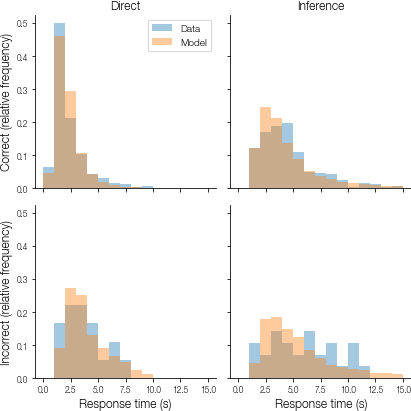

In [45]:
g = model.plot_fit(data, fit_nav)
g.savefig(os.path.join(model_dir, 'lba_nav_fit.pdf'))

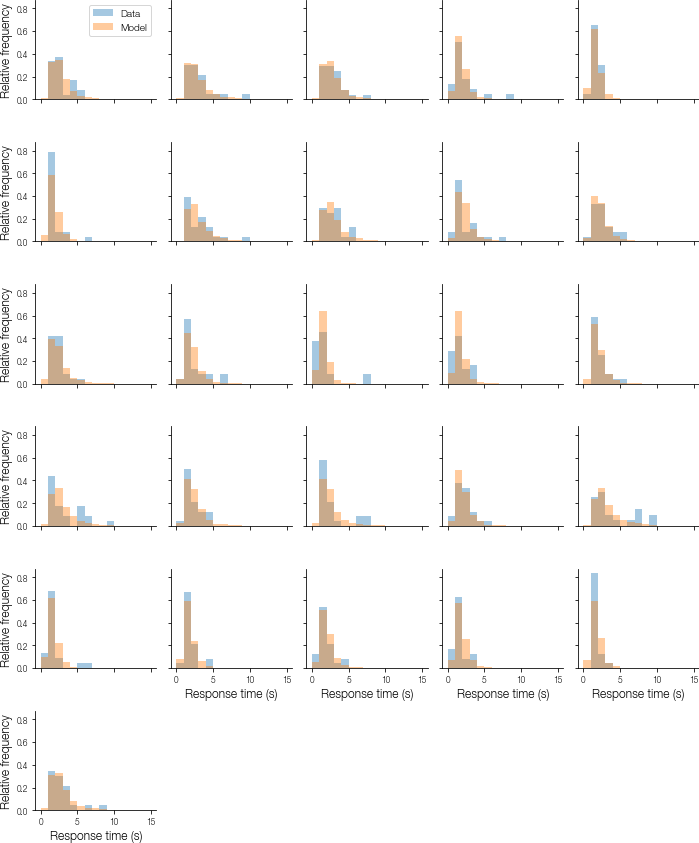

In [46]:
g = model.plot_fit_subj(data, fit_nav, 1)
g.savefig(os.path.join(model_dir, 'lba_nav_direct.pdf'))

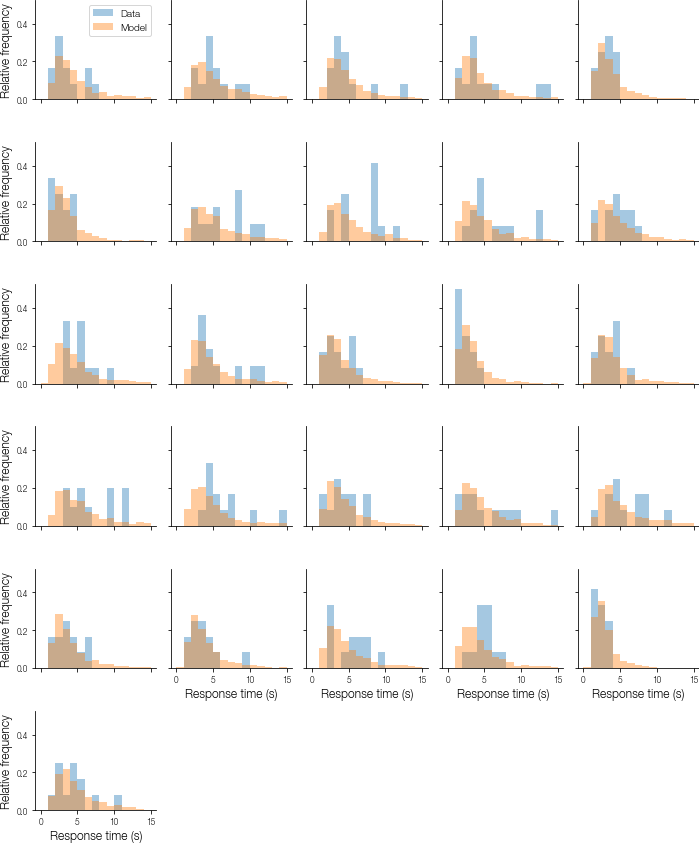

In [47]:
g = model.plot_fit_subj(data, fit_nav, 2)
g.savefig(os.path.join(model_dir, 'lba_nav_inference.pdf'))

## Summarize posterior parameters

Visualize the posterior probability of each parameter. Also calculate an average for each parameter, to use for posterior predictive sampling.

Note that v3 is referred to as v2 in the manuscript, so it is named differently in the plots.

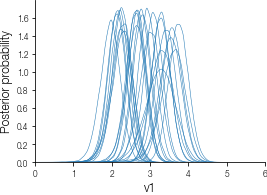

In [43]:
# v1 individual subject parameters
fig, ax = plt.subplots(figsize=(4, 3))
n_subj = trace_nav['v1'].shape[1]
for i in range(n_subj):
    sns.distplot(trace_nav['v1'][:, i], hist=False, 
                 kde_kws={'color': 'C0', 'linewidth': .5})
ax.set_xlim(0, 6)
h = ax.set_xlabel('v1')
h = ax.set_ylabel('Posterior probability')
fig.savefig(os.path.join(model_dir, 'lba_nav_post_v1.pdf'))

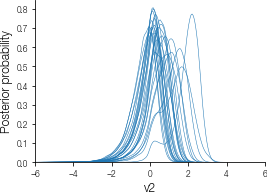

In [44]:
# v3 individual subject parameters
fig, ax = plt.subplots(figsize=(4, 3))
n_subj = trace_nav['v3'].shape[1]
for i in range(n_subj):
    sns.distplot(trace_nav['v3'][:, i], hist=False, 
                 kde_kws={'color': 'C0', 'linewidth': .5})
ax.set_xlim(-6, 6)
h = ax.set_xlabel('v2')
h = ax.set_ylabel('Posterior probability')
fig.savefig(os.path.join(model_dir, 'lba_nav_post_v3.pdf'))

## Load neural measures

Vector analysis used a bootstrap that scrambled items within triad, breaking the consistent direction between A and C. A high z-statistic from this test indicates consistent A-C direction. The "vectri" (vector triad) analysis instead scrambled across triads, so that the z-statistic of the error tests for separation between triads.

In [12]:
# load RTs for correct trials
rtc = task.test_rt(data_dir)

# load signals that may predict RT model parameters
df_vector = rsa.load_zstat_full(os.path.join(rsa_dir, 
                                             'prepost_fix2_triad_vector_ac'))
vec = rsa.zstat_pivot(df_vector, 'pos')
df_vectri = rsa.load_zstat_full(os.path.join(rsa_dir, 
                                             'prepost_fix2_triad_vectri_ac'))
tri = rsa.zstat_pivot(df_vectri, 'pos')

# posterior estimates of model parameters
param, subj_param = model_nav.post_param(trace_nav)
df_subj = pd.DataFrame(subj_param)

In [13]:
# combine into one dataset
df = pd.DataFrame({'subj_id': rtc.index.values,
                   'rt1': rtc.AB.values, 'rt2': rtc.BC.values, 
                   'rt3': rtc.AC.values,
                   'v1': df_subj.v1.values, 'v3': df_subj.v3.values})
for roi in ['lhpc', 'llpc', 'lphc']:
    df['vec_' + roi] = vec[roi].values
df['tri_lphc'] = tri['lphc'].values

               rt1       rt2       rt3        v1        v3  vec_lhpc  \
rt1       1.000000  0.503174  0.444431 -0.466116 -0.411001 -0.154729   
rt2       0.503174  1.000000  0.479284 -0.809014 -0.450540 -0.325091   
rt3       0.444431  0.479284  1.000000 -0.596527 -0.825394 -0.395998   
v1       -0.466116 -0.809014 -0.596527  1.000000  0.464591  0.433868   
v3       -0.411001 -0.450540 -0.825394  0.464591  1.000000  0.280356   
vec_lhpc -0.154729 -0.325091 -0.395998  0.433868  0.280356  1.000000   
vec_llpc -0.106919 -0.160132 -0.419269  0.256871  0.461898  0.250006   
vec_lphc -0.075917 -0.032963 -0.272875  0.016812  0.313528  0.300181   
tri_lphc -0.217607 -0.360227 -0.323425  0.202807  0.542898 -0.026875   

          vec_llpc  vec_lphc  tri_lphc  
rt1      -0.106919 -0.075917 -0.217607  
rt2      -0.160132 -0.032963 -0.360227  
rt3      -0.419269 -0.272875 -0.323425  
v1        0.256871  0.016812  0.202807  
v3        0.461898  0.313528  0.542898  
vec_lhpc  0.250006  0.300181 -0.0

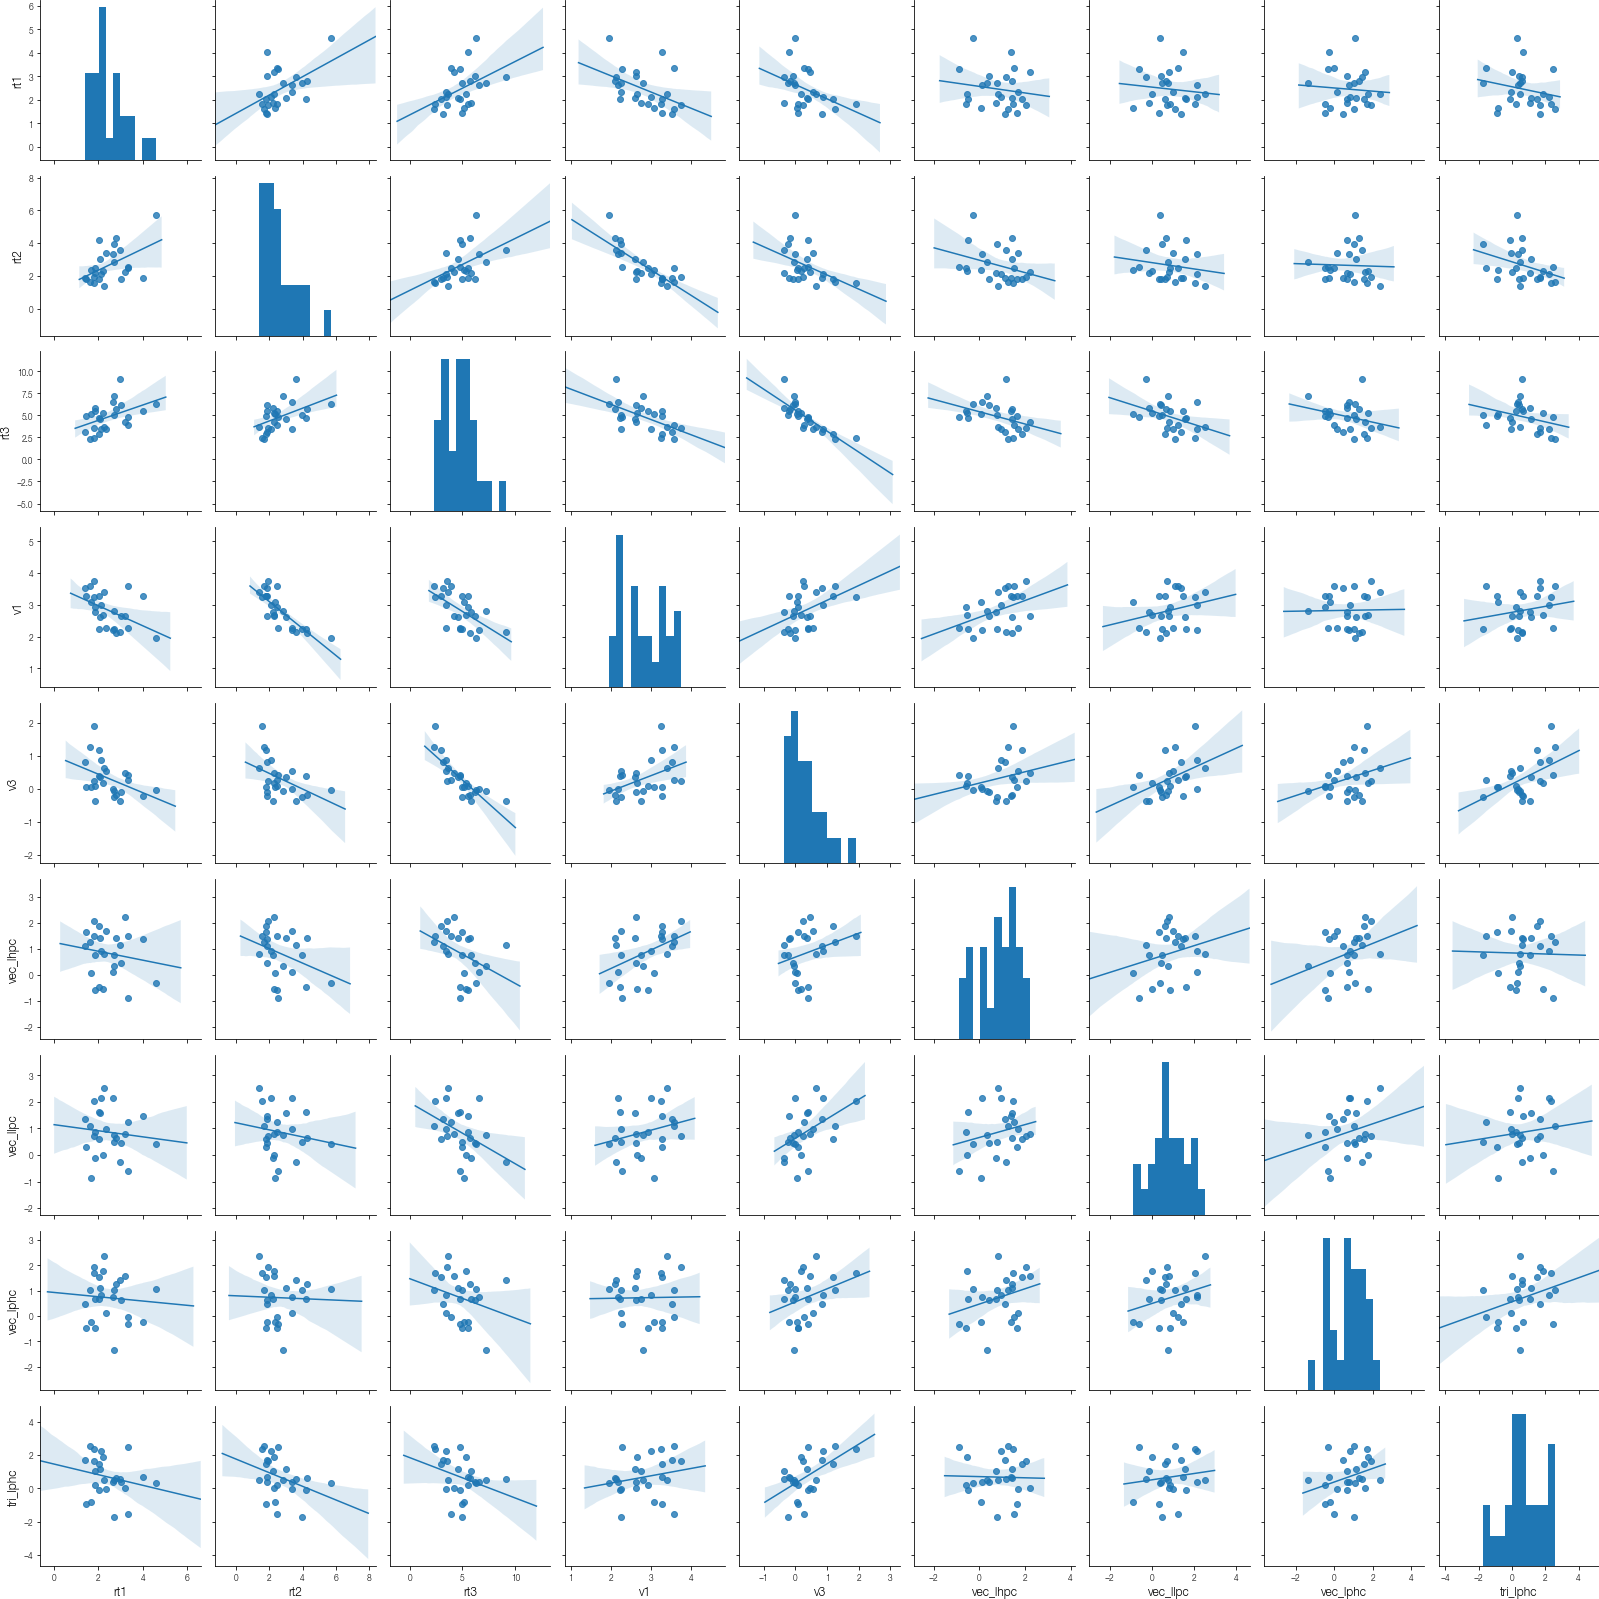

In [14]:
print(df.corr())
g = sns.pairplot(df, kind='reg')
g.savefig(os.path.join(model_dir, 'lba_nav_pairs.pdf'))

## Test relationship between neural measures and RT parameters

In [15]:
# add residualized parameters
res = smf.ols(formula='v1 ~ v3', data=df).fit()
df.loc[:, 'v1_ctrl_v3'] = res.resid
res = smf.ols(formula='v3 ~ v1', data=df).fit()
df.loc[:, 'v3_ctrl_v1'] = res.resid

In [16]:
res = smf.ols(formula='vec_lhpc ~ v1 + v3', data=df).fit()
display(res.summary())
print(f"v1: p={res.pvalues['v1']/2}")
print(f"v3: p={res.pvalues['v3']/2}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               vec_lhpc   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     2.806
Date:                Thu, 21 May 2020   Prob (F-statistic):             0.0812
Time:                        15:05:11   Log-Likelihood:                -30.498
No. Observations:                  26   AIC:                             67.00
Df Residuals:                      23   BIC:                             70.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0209      0.949     -1.075      0.293      -2.985       0.943
v1             0.6366      0.347      1.834      0.080      -0.081       1.355
v3             0.1644      0.345      0.476      0.639      -0.550       0.879
==============================================================================
Omnibus:                        0.497   Durbin-Watson:                   2.299
Prob(Omnibus):                  0.780   Jarque-Bera (JB):                0.601
Skew:                          -0.126   Prob(JB):                        0.741
Kurtosis:                       2.299   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

v1: p=0.03981157676055461
v3: p=0.31931554622292124


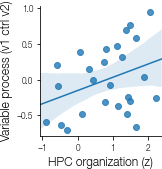

In [17]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))
h = sns.regplot('vec_lhpc', 'v1_ctrl_v3', data=df)
h = ax.set_xlabel('HPC organization (z)')
h = ax.set_ylabel('Variable process (v1 ctrl v2)')
fig.savefig(os.path.join(model_dir, 'lba_nav_vec_hpc_v1.pdf'))

In [18]:
res = smf.ols(formula='vec_llpc ~ v1 + v3', data=df).fit()
display(res.summary())
print(f"v1: p={res.pvalues['v1']/2}")
print(f"v3: p={res.pvalues['v3']/2}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               vec_llpc   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     3.161
Date:                Thu, 21 May 2020   Prob (F-statistic):             0.0612
Time:                        15:05:12   Log-Likelihood:                -29.314
No. Observations:                  26   AIC:                             64.63
Df Residuals:                      23   BIC:                             68.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3988      0.907      0.440      0.664      -1.478       2.275
v1             0.0857      0.332      0.259      0.798      -0.600       0.772
v3             0.6914      0.330      2.095      0.047       0.009       1.374
==============================================================================
Omnibus:                        0.262   Durbin-Watson:                   2.670
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.001
Skew:                           0.002   Prob(JB):                         1.00
Kurtosis:                       2.976   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

v1: p=0.39914858699734207
v3: p=0.023701532608942272


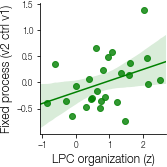

In [19]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))
h = sns.regplot('vec_llpc', 'v3_ctrl_v1', data=df, color='g')
h = ax.set_xlabel('LPC organization (z)')
h = ax.set_ylabel('Fixed process (v2 ctrl v1)')
fig.savefig(os.path.join(model_dir, 'lba_nav_vec_lpc_v3.pdf'))

In [20]:
res = smf.ols(formula='vec_lphc ~ v1 + v3', data=df).fit()
display(res.summary())
print(f"v1: p={res.pvalues['v1']/2}")
print(f"v3: p={res.pvalues['v3']/2}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               vec_lphc   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.560
Date:                Thu, 21 May 2020   Prob (F-statistic):              0.231
Time:                        15:05:12   Log-Likelihood:                -31.832
No. Observations:                  26   AIC:                             69.66
Df Residuals:                      23   BIC:                             73.44
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2860      0.999      1.287      0.211      -0.781       3.353
v1            -0.2717      0.365     -0.744      0.465      -1.028       0.484
v3             0.6416      0.364      1.764      0.091      -0.111       1.394
==============================================================================
Omnibus:                        0.028   Durbin-Watson:                   2.764
Prob(Omnibus):                  0.986   Jarque-Bera (JB):                0.169
Skew:                          -0.067   Prob(JB):                        0.919
Kurtosis:                       2.629   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

v1: p=0.23230586733269226
v3: p=0.04546695912313883


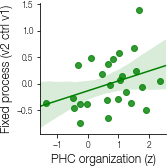

In [21]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))
h = sns.regplot('vec_lphc', 'v3_ctrl_v1', data=df, color='g')
h = ax.set_xlabel('PHC organization (z)')
h = ax.set_ylabel('Fixed process (v2 ctrl v1)')
fig.savefig(os.path.join(model_dir, 'lba_nav_vec_phc_v3.pdf'))

In [22]:
res = smf.ols(formula='tri_lphc ~ v1 + v3', data=df).fit()
display(res.summary())
print(f"v1: p={res.pvalues['v1']/2}")
print(f"v3: p={res.pvalues['v3']/2}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               tri_lphc   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     4.878
Date:                Thu, 21 May 2020   Prob (F-statistic):             0.0171
Time:                        15:05:13   Log-Likelihood:                -35.925
No. Observations:                  26   AIC:                             77.85
Df Residuals:                      23   BIC:                             81.62
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6699      1.170      0.573      0.572      -1.750       3.090
v1            -0.1366      0.428     -0.319      0.752      -1.021       0.748
v3             1.2342      0.426      2.900      0.008       0.354       2.115
==============================================================================
Omnibus:                        1.163   Durbin-Watson:                   1.234
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                1.101
Skew:                          -0.377   Prob(JB):                        0.577
Kurtosis:                       2.330   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

v1: p=0.3761505565331401
v3: p=0.004036865315086509


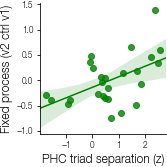

In [23]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))
h = sns.regplot('tri_lphc', 'v3_ctrl_v1', data=df, color='g')
h = ax.set_xlabel('PHC triad separation (z)')
h = ax.set_ylabel('Fixed process (v2 ctrl v1)')
fig.savefig(os.path.join(model_dir, 'lba_nav_tri_phc_v3.pdf'))

In [25]:
f = 'v1_ctrl_v3 ~ vec_lhpc + vec_llpc + vec_lphc + tri_lphc'
res = smf.ols(formula=f, data=df).fit()
display(res.summary())
print(f"hpc: p={res.pvalues['vec_lhpc'] / 2}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             v1_ctrl_v3   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.210
Date:                Thu, 21 May 2020   Prob (F-statistic):              0.336
Time:                        15:05:14   Log-Likelihood:                -14.550
No. Observations:                  26   AIC:                             39.10
Df Residuals:                      21   BIC:                             45.39
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0962      0.157     -0.613      0.546      -0.423       0.230
vec_lhpc       0.2311      0.114      2.021      0.056      -0.007       0.469
vec_llpc       0.0047      0.116      0.041      0.968      -0.236       0.246
vec_lphc      -0.1555      0.119     -1.311      0.204      -0.402       0.091
tri_lphc       0.0183      0.086      0.213      0.833      -0.160       0.196
==============================================================================
Omnibus:                        0.391   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.822   Jarque-Bera (JB):                0.527
Skew:                           0.021   Prob(JB):                        0.768
Kurtosis:                       2.303   Cond. No.                         3.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

hpc: p=0.028092204494930748


In [27]:
m1 = smf.ols(formula='v3_ctrl_v1 ~ vec_lhpc', data=df).fit()
m2 = smf.ols(formula='v3_ctrl_v1 ~ vec_lhpc + vec_llpc + vec_lphc + tri_lphc',
             data=df).fit()
aov = anova.anova_lm(m1, m2)
aov

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,24.0,5.747324,0.0,NaN,NaN,NaN
1,21.0,3.616814,3.0,2.13051,4.123399,0.019047
